imports

In [1]:
import torch
import os
import numpy as np
from tqdm import tqdm

import pandas as pd

from myhelpers import cifar_dataLoader

from HGNN.train.configParser import ConfigParser
from HGNN.train import CNN, dataLoader
from myhelpers.memory import get_cuda_memory
from myhelpers.image_show import showExample, getClosestImageFromDataloader
from myhelpers.images_tsne import get_tsne
from misc import get_classification_df

experimetnsFileName = "experiments.csv"

parameters

In [12]:
experimentsPath="/raid/elhamod/Fish/experiments/"
dataPath="/raid/elhamod/Fish/"
experimentName="Fish50_30-5run-BB-HGNN-crossvalidation"
trial_hash="5d3ce421dd81e0c286d9e932e1f6ac15cb57d86bbd84612f8f606296" #BB
SEED_INT=4 # order of the trial_hash when executed

legends=['fine', 'coarse']
use_submodel=False
dataset_name="test"
cuda=0
batch_size = 4
num_workers = 8

cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)
    
torch.multiprocessing.set_start_method('spawn')

using cuda 0


Get dataset

In [4]:
# Get experiment parameters
experimentsFileNameAndPath = os.path.join(experimentsPath, experimetnsFileName)
if os.path.exists(experimentsFileNameAndPath):
    experiments_df = pd.read_csv(experimentsFileNameAndPath)
    experiments_df = experiments_df.where(pd.notnull(experiments_df), None)
else:
    raise Exception("Experiment not " + trial_hash + " found!")
experimentRecord = experiments_df[experiments_df["trialHash"] == trial_hash]
# experiment_params = experimentRecord.to_dict('records')[0]
experiment_params = {"image_path": "Curated4/Easy_30", "suffix": None, "useCrossValidation": True, "img_res": 448, "augmented": True, "batchSize": 64, "learning_rate": 0.001, "numOfTrials": 5, "fc_layers": 1, "pretrained": True, "epochs": 120, "patience": -1, "optimizer": "adabelief", "scheduler": "plateau", "weightdecay": 0.01, "scheduler_gamma": 0.5, "scheduler_patience": 15, "modelType": "BB", "lambda": 1, "two_phase_lambda": False, "tl_model": "ResNet18", "link_layer": "avgpool", "adaptive_smoothing": True, "adaptive_lambda": 0.1, "adaptive_alpha": 0.5, "tripletEnabled": False, "regularTripletLoss": False, "tripletSamples": 2, "tripletSelector": "semihard", "tripletMargin": 2, "triplet_layers_dic": "layer2,layer4", "L1reg": False, "phylogeny_loss": False, "grayscale": False, "tl_extralayer": False, "random_fitting": False, "displayName": "Fish-crossval-BB-Fish30", "noSpeciesBackprop": False, "phylogeny_loss_epsilon": 0.03, "phyloDistances": "0.75,0.5,0.25", "addKernelOrthogonality": False, "useImbalancedSampling": False, "useImbalancedCriterion": False}
print(experiment_params)

config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
experiment_params = config_parser.fixExperimentParams(experiment_params)
experimentPathAndName = os.path.join(experimentsPath, experimentName)
if experiment_params['image_path'] == 'cifar-100-python':
    datasetManager = cifar_dataLoader.datasetManager(experimentPathAndName, dataPath)
else:
    datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)
datasetManager.updateParams(config_parser.fixPaths(experiment_params))
train_loader, validation_loader, test_loader = datasetManager.getLoaders(SEED_INT)

dataloader = torch.utils.data.DataLoader(test_loader.dataset if dataset_name=="test" else train_loader.dataset, pin_memory=True, batch_size=batch_size, num_workers=num_workers)
dataset = dataloader.dataset

{'image_path': 'Curated4/Easy_30', 'suffix': None, 'useCrossValidation': True, 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 0.001, 'numOfTrials': 5, 'fc_layers': 1, 'pretrained': True, 'epochs': 120, 'patience': -1, 'optimizer': 'adabelief', 'scheduler': 'plateau', 'weightdecay': 0.01, 'scheduler_gamma': 0.5, 'scheduler_patience': 15, 'modelType': 'BB', 'lambda': 1, 'two_phase_lambda': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.1, 'adaptive_alpha': 0.5, 'tripletEnabled': False, 'regularTripletLoss': False, 'tripletSamples': 2, 'tripletSelector': 'semihard', 'tripletMargin': 2, 'triplet_layers_dic': 'layer2,layer4', 'L1reg': False, 'phylogeny_loss': False, 'grayscale': False, 'tl_extralayer': False, 'random_fitting': False, 'displayName': 'Fish-crossval-BB-Fish30', 'noSpeciesBackprop': False, 'phylogeny_loss_epsilon': 0.03, 'phyloDistances': '0.75,0.5,0.25', 'addKernelOrthogonality': False, 'useImbalan

Get untrained model

In [5]:
%%capture

# architecture = {
#     "fine": len(dataset.csv_processor.getFineList()),
#     "coarse" : len(dataset.csv_processor.getCoarseList())
# }
architecture = CNN.get_architecture(experiment_params, train_loader.dataset.csv_processor)
model = CNN.create_model(architecture, experiment_params, cuda)

# get the model and the parameters
# modelName = experimentRecord.iloc[0]["modelName"]
modelName = "models/5d3ce421dd81e0c286d9e932e1f6ac15cb57d86bbd84612f8f606296"
trialName = os.path.join(experimentPathAndName, modelName)
_ = CNN.loadModel(model, trialName)
model.eval()

Show example and closest images

Show TSNE

In [6]:
# activation_layer = 'layer2'#'fine'
# activation_layer ='01distance'

model_sub = model
if hasattr(model, 'network_fine') and use_submodel==True:
    model_sub = model.network_fine

# get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
#                 os.path.join(experimentPathAndName, modelName), 
#                 dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

In [7]:
# activation_layer = 'layer4'#'fine'
# activation_layer ='03distance'

# get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
#                 os.path.join(experimentPathAndName, modelName), 
#                 dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

In [8]:
# activation_layer ='coarse'

# get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
#                 os.path.join(experimentPathAndName, modelName), 
#                 dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

  0%|          | 0/57 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'detach'

100%|██████████| 57/57 [00:02<00:00, 19.00it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 228 samples in 0.001s...
[t-SNE] Computed neighbors for 228 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 228 / 228
[t-SNE] Mean sigma: 5.166359
[t-SNE] Computed conditional probabilities in 0.023s
[t-SNE] Iteration 50: error = 60.6291504, gradient norm = 0.6192694 (50 iterations in 0.037s)
[t-SNE] Iteration 100: error = 60.7590408, gradient norm = 0.5955452 (50 iterations in 0.026s)
[t-SNE] Iteration 150: error = 61.9792099, gradient norm = 0.5765150 (50 iterations in 0.026s)
[t-SNE] Iteration 200: error = 60.6868744, gradient norm = 0.5924047 (50 iterations in 0.031s)
[t-SNE] Iteration 250: error = 59.3700714, gradient norm = 0.6151786 (50 iterations in 0.025s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.370071
[t-SNE] Iteration 300: error = 0.3429710, gradient norm = 0.0068885 (50 iterations in 0.029s)
[t-SNE] Iteration 350: error = 0.3098752, gradient norm = 0.0004723 (

100%|██████████| 57/57 [00:03<00:00, 16.79it/s]


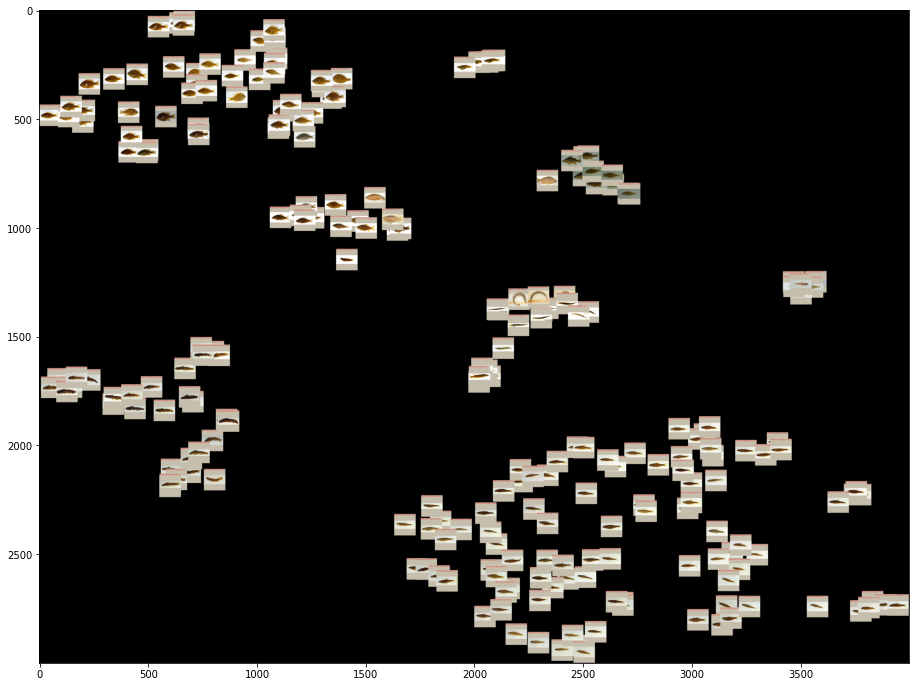

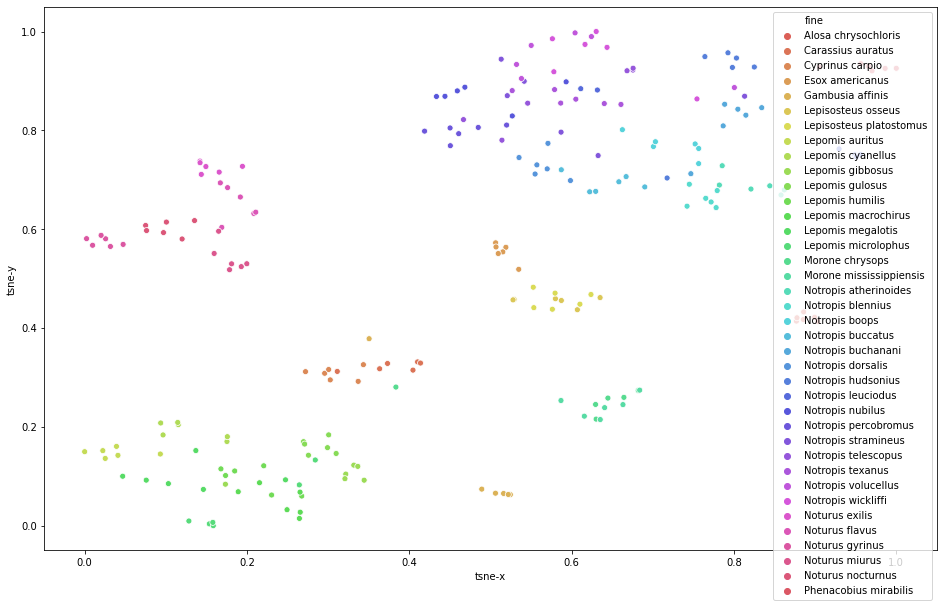

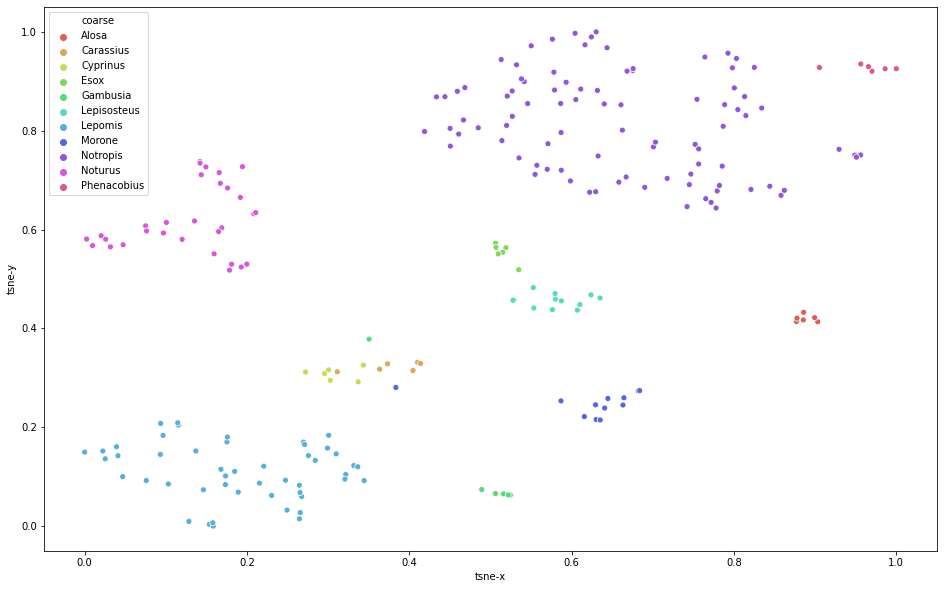

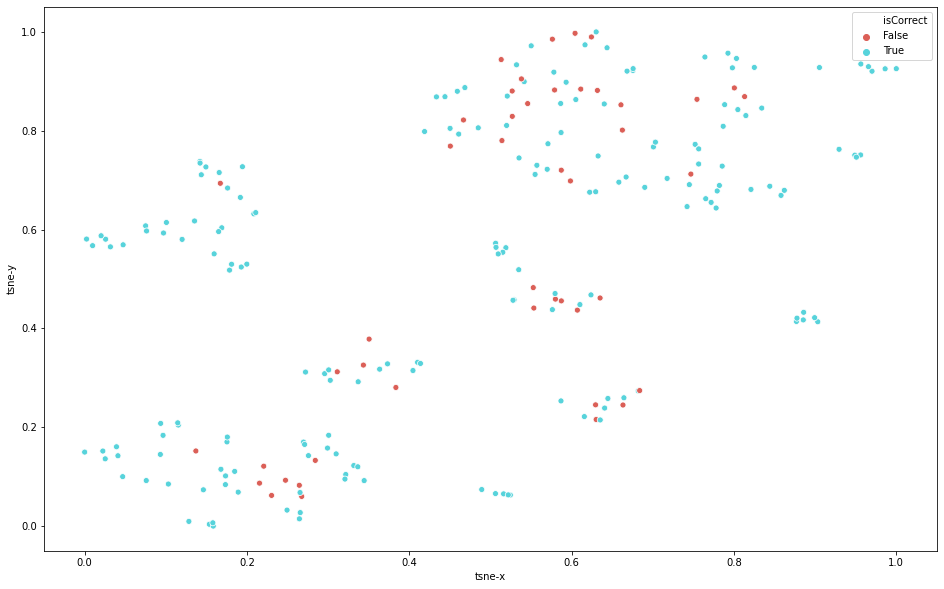

In [9]:
activation_layer = 'fine'#'fine'

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

In [ ]:
# activation_layer = 'layer4_features'#'fine'

# get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
#                 os.path.join(experimentPathAndName, modelName), 
#                 dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

In [10]:
#dict_keys(['input', 'gap_features', 'layer4_features', 'fine', '05distance', '03distance', '01distance'])
# activation_layer ='gap_features'
activation_layer ='fine'

X = None
Y= None
Z= None
a, n, _ = dataloader.dataset.toggle_image_loading(dataloader.dataset.augmentation_enabled, True)
for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    image2 = batch['image'] 
    fine_label = batch['fine']
    if cuda is not None:
        image2 = image2.cuda()
    activations = model.activations(image2)
    features2 = activations[activation_layer].detach().cpu()
    features2 = features2.reshape(features2.shape[0], -1)
    pred, _ = CNN.getPredictions(activations['fine'], [])

    # Calculate distance for each pair.
    X = features2 if X is None else torch.cat([X, features2]).detach()
    Y = fine_label.tolist() if Y is None else Y + fine_label.tolist()
    Z = pred.tolist() if Z is None else Z + pred.tolist()
dataloader.dataset.toggle_image_loading(a, n)




100%|██████████| 57/57 [00:03<00:00, 15.90it/s]


(False, True, True)

/home/elhamod/melhamodenv3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/elhamod/melhamodenv3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


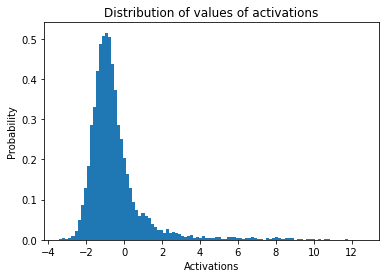

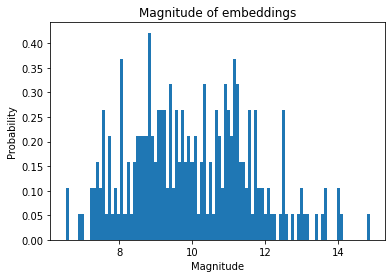

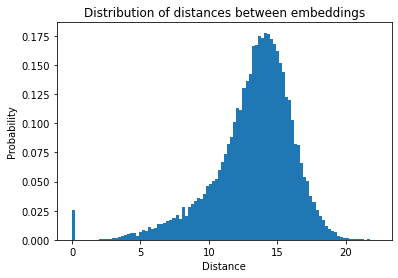

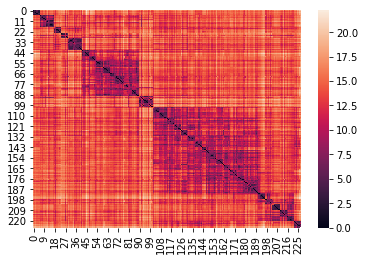

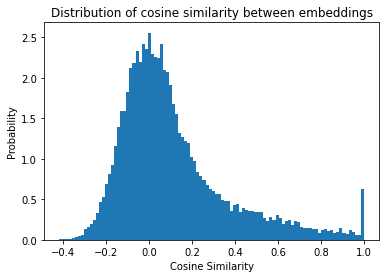

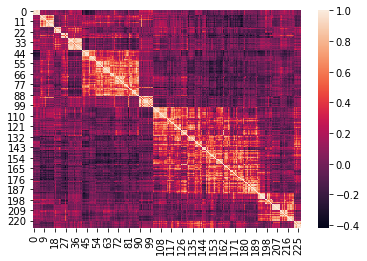

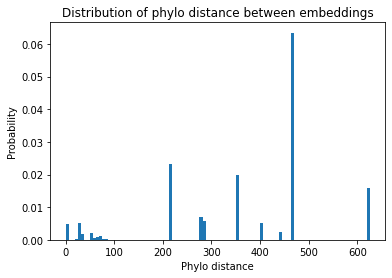

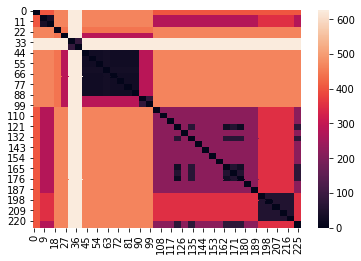

In [13]:

import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial as sp
from sklearn.metrics import confusion_matrix

x = X.reshape(1,-1)
fig = plt.figure(0)
plt.hist(x, bins=100, density=True, label="activations")
# mn, mx = plt.xlim()
# plt.xlim(mn, mx)
# kde = st.gaussian_kde(x)
# print(kde)
# kde_xs = np.linspace(kde, kde, 300)
# plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
# plt.legend(loc="upper left")
plt.ylabel("Probability")
plt.xlabel("Activations")
plt.title("Distribution of values of activations");
fig.savefig(os.path.join(experimentPathAndName, 'models',trial_hash, "{}_{}_{}.png".format(dataset_name,activation_layer,'values')))

fig = plt.figure(1)
sqr = torch.sqrt(torch.sum(torch.pow(X, 2), 1).reshape(-1))
plt.hist(sqr, density=True, bins=100, label="magnitude")
plt.ylabel("Probability")
plt.xlabel("Magnitude")
plt.title("Magnitude of embeddings");
fig.savefig(os.path.join(experimentPathAndName, 'models',trial_hash, "{}_{}_{}.png".format(dataset_name,activation_layer,'magnitudes')))

fig = plt.figure(2)
sqrA = torch.sum(torch.pow(X, 2), 1, keepdim=True).expand(X.shape[0], x.shape[0])
sqrB = torch.sum(torch.pow(X, 2), 1, keepdim=True).expand(X.shape[0], x.shape[0]).t()
ans =  torch.sqrt(sqrA - 2*torch.mm(X, X.t()) + sqrB)
ans2 = ans[torch.triu_indices(ans.shape[0],ans.shape[1])[0], torch.triu_indices(ans.shape[0],ans.shape[1])[1]]
plt.hist(ans2, density=True, bins=100, label="distances")
plt.ylabel("Probability")
plt.xlabel("Distance")
plt.title("Distribution of distances between embeddings");
fig.savefig(os.path.join(experimentPathAndName, 'models',trial_hash, "{}_{}_{}.png".format(dataset_name,activation_layer,'distances')))

fig = plt.figure(3)
ax = sns.heatmap(ans)
plt.show()
fig.savefig(os.path.join(experimentPathAndName, 'models',trial_hash, "{}_{}_{}.png".format(dataset_name,activation_layer,'distances_heat_map')))

fig = fig = plt.figure(4)
ans = 1 - sp.distance.cdist(X, X, 'cosine')
ans2 = ans[torch.triu_indices(ans.shape[0],ans.shape[1])[0], torch.triu_indices(ans.shape[0],ans.shape[1])[1]]
plt.hist(ans2, density=True, bins=100, label="similarity")
plt.ylabel("Probability")
plt.xlabel("Cosine Similarity")
plt.title("Distribution of cosine similarity between embeddings");
fig.savefig(os.path.join(experimentPathAndName, 'models',trial_hash, "{}_{}_{}.png".format(dataset_name,activation_layer,'similarity')))

fig = plt.figure(5)
ax = sns.heatmap(ans)
plt.show()
fig.savefig(os.path.join(experimentPathAndName, 'models',trial_hash, "{}_{}_{}.png".format(dataset_name,activation_layer,'similarity_heat_map')))

csv_processor = dataloader.dataset.csv_processor
fig = fig = plt.figure(6)
ans = torch.zeros(len(Y),len(Y))
for indx, i in enumerate(Y):
    for indx2, j in enumerate(Y[indx+1:]):
#         print(csv_processor.getFineList()[i], csv_processor.getFineList()[j],csv_processor.tax.get_distance(csv_processor.getFineList()[i], csv_processor.getFineList()[j]))
        dist = csv_processor.tax.get_distance(csv_processor.getFineList()[i], csv_processor.getFineList()[j])
        ans[indx][indx2+1+indx] = ans[indx2+1+indx][indx] = dist
        
ans2 = ans[torch.triu_indices(ans.shape[0],ans.shape[1])[0], torch.triu_indices(ans.shape[0],ans.shape[1])[1]]
plt.hist(ans2, density=True, bins=100, label="phylo distance")
plt.ylabel("Probability")
plt.xlabel("Phylo distance")
plt.title("Distribution of phylo distance between embeddings");
fig.savefig(os.path.join(experimentPathAndName, 'models',trial_hash, "{}_{}_{}.png".format(dataset_name,activation_layer,'phylo_distance')))

fig = plt.figure(7)
ax = sns.heatmap(ans)
plt.show()
fig.savefig(os.path.join(experimentPathAndName, 'models',trial_hash, "{}_{}_{}.png".format(dataset_name,activation_layer,'phylo_distance_heat_map')))

# fig = plt.figure(8)
# cf_matrix = confusion_matrix(Y, Z)
# ax = sns.heatmap(cf_matrix, cmap='Blues')

In [ ]:
len(Z)

In [14]:
print(model)

CNN_One_Net(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr